# OptimizedBot optimization

In [2]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from tqdm.notebook import trange
from copy import deepcopy
from itertools import combinations
import joblib

sys.path.append('..')
from blockade import Blockade
from players.OptimizedBot import OptimizedBot
from players.HeuristicBot import HeuristicBot
from players.RandomBot import RandomBot

## Testing `arena_size` vs game time relation

Outcomes (and times) for arena_size=10:
2 (0.51s);	1 (0.45s);	1 (0.41s);	0 (0.5s);	1 (0.49s);	1 (0.52s);	2 (0.29s);	2 (0.31s);	1 (0.28s);	1 (0.51s);	
Average time: 0.43s
Outcomes (and times) for arena_size=11:
2 (0.72s);	0 (0.37s);	1 (0.66s);	1 (0.71s);	1 (0.7s);	2 (0.74s);	1 (0.7s);	2 (0.4s);	1 (0.37s);	1 (0.59s);	
Average time: 0.59s
Outcomes (and times) for arena_size=12:
0 (0.47s);	1 (0.68s);	2 (0.45s);	2 (0.5s);	1 (0.93s);	0 (0.94s);	2 (0.46s);	2 (0.51s);	1 (0.48s);	2 (0.51s);	
Average time: 0.59s
Outcomes (and times) for arena_size=13:
2 (1.12s);	0 (0.7s);	1 (0.97s);	0 (1.26s);	0 (1.3s);	2 (0.68s);	0 (0.97s);	1 (1.27s);	1 (1.36s);	2 (0.63s);	
Average time: 1.02s
Outcomes (and times) for arena_size=14:
2 (0.83s);	2 (1.7s);	1 (1.54s);	1 (1.52s);	2 (0.83s);	2 (0.82s);	1 (1.96s);	2 (1.14s);	1 (0.82s);	2 (0.79s);	
Average time: 1.2s
Outcomes (and times) for arena_size=15:
1 (2.23s);	2 (2.34s);	1 (1.04s);	0 (2.06s);	2 (1.02s);	2 (0.98s);	1 (1.95s);	1 (1.99s);	1 (2.42s);	0 (1.36s);	
Ave

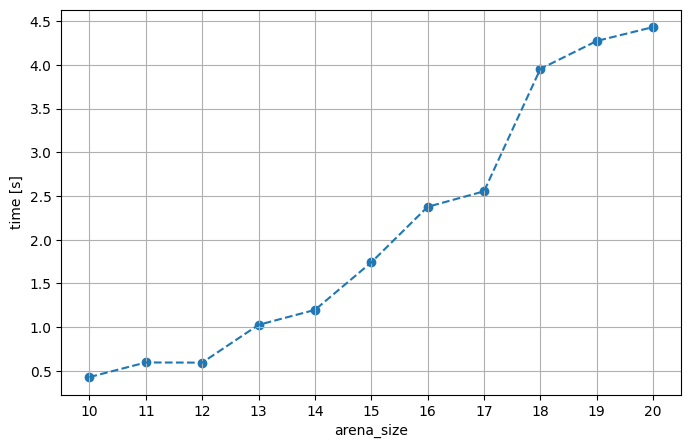

In [8]:
avg_test_run_times = []
arena_sizes = list(range(10, 21))

for arena_size in arena_sizes:
    print(f'Outcomes (and times) for arena_size={arena_size}:')
    test_run_times = []
    for seed in range(10):
        random.seed(seed)

        start = perf_counter()
        game = Blockade(player1=OptimizedBot(weights=[1.0, 1.0, 1.0, 0.0], verbose=False),
                        player2=OptimizedBot(weights=[1.0, 1.0, 1.0, 0.0], verbose=False),
                        arena_size=arena_size,
                        verbose=False)
        outcome = game.run_windowless()
        stop = perf_counter()
        test_run_times.append(stop-start)
        print(f'{outcome} ({np.round(test_run_times[-1], 2)}s);\t', end='')

    avg_test_run_times.append(np.mean(test_run_times))
    print(f'\nAverage time: {np.round(avg_test_run_times[-1], 2)}s')
    
plt.figure(figsize=(8, 5))
plt.scatter(arena_sizes, avg_test_run_times)
plt.plot(arena_sizes, avg_test_run_times, linestyle='--')
plt.grid()
plt.xticks(arena_sizes)
plt.xlabel('arena_size')
plt.ylabel('time [s]')
plt.show()
plt.close()

Conclusion: lower `arena_size` should be used to speed-up optimization. Let's use `arena_size=15` as a compromise.

## Evolutionary optimization

In [55]:
def init_random_population(num_weights, pop_size):
    return [np.random.random(num_weights) * 2 - 1 for _ in range(pop_size)]

def crossover(individual1, individual2):
    # averaging crossover
    return np.mean([individual1, individual2], axis=0)

def reflected_normal_distribution(loc, scale, min_val=-1.0, max_val=1.0):
    # safely get a number from normal distribution
    # in case the value is out of the allowed scope, use the fractional part to get the closest allowed value
    base_val = np.random.normal(loc, scale)
    if base_val < min_val:
        fractional_part = base_val % min_val
        return min(fractional_part, min_val - fractional_part)
    elif base_val > max_val:
        fractional_part = base_val % max_val
        return max(fractional_part, max_val - fractional_part)
    else:
        return base_val

def mutation(individual, prob, scale):
    # gaussian mutation with reflection
    return np.array([(reflected_normal_distribution(weight, scale) if np.random.random() < prob else weight) for weight in individual])

def tournament_selection(participants, arena_size, repetitions, score_dict, recursion_depth=2):
    # true football-style tournament
    scores = np.zeros(len(participants))
    for rep in range(repetitions):
        for p1, p2 in combinations(list(range(len(participants))), 2):
            if rep % 2:
                # switch sides every second repetition
                p1, p2 = p2, p1
            game = Blockade(player1=OptimizedBot(weights=participants[p1], verbose=False),
                            player2=OptimizedBot(weights=participants[p2], verbose=False),
                            arena_size=arena_size,
                            verbose=False)
            outcome = game.run_windowless()
            if outcome == 1:
                scores[p1] += score_dict['won']
                scores[p2] += score_dict['lost']
            elif outcome == 2:
                scores[p1] += score_dict['lost']
                scores[p2] += score_dict['won']
            else:
                scores[p1] += score_dict['drew']
                scores[p2] += score_dict['drew']

    best_participants = np.argwhere(scores == np.amax(scores))
    if len(best_participants) > 1 and recursion_depth > 0:
        # perform an additional mini-tournament without repetitions in case of a tie (limited by recursion_depth)
        tied_best_participants = [participants[int(i)] for i in best_participants]
        return tournament_selection(tied_best_participants, arena_size, 1, score_dict, recursion_depth-1)
    else:
        return participants[int(best_participants[0])]
    
def bot_evolution(arena_size, pop_size, num_generations, mutation_prob, mutation_scale, 
                  tournament_size, tournament_repetitions, tournament_score_dict={'won': 3, 'lost': 0, 'drew': 1}, 
                   num_weights=4, seed=42):
    # custom evolutionary algorithm
    np.random.seed(seed)
    weight_history = [[[] for _ in range(num_generations)] for _ in range(num_weights)] # only used for plotting history
    population = init_random_population(num_weights, pop_size)
    for generation in trange(num_generations):
        # save weights
        for individual in population:
            for i in range(num_weights):
                weight_history[i][generation].append(individual[i])

        # crossover & mutation
        child_population = []
        while len(child_population) < pop_size:
            parents = np.random.choice(list(range(pop_size)), 2, replace=False)
            child = crossover(population[int(parents[0])], population[int(parents[1])])
            mutated_child = mutation(child, mutation_prob, mutation_scale)
            child_population.append(mutated_child)

        # tournament selection out of joined parent and child population
        new_population = []
        joined_populations = population + child_population
        if len(joined_populations) != pop_size * 2:
            print(f'ERROR: wrong tournament size: {len(joined_populations)} (should be {pop_size * 2})')
            break
        while len(new_population) < pop_size:
            tournament_participants = [joined_populations[i] for i in np.random.choice(list(range(pop_size * 2)), tournament_size, replace=False)]
            tournament_winner = tournament_selection(tournament_participants, arena_size, tournament_repetitions, tournament_score_dict)
            new_population.append(tournament_winner)

        # replace population
        population = new_population

    # select the final best solution in another tournament
    best_solution = tournament_selection(population, arena_size, tournament_repetitions, tournament_score_dict)
    print('Best solution:')
    print(best_solution)
    
    return weight_history

## Show evolution history

In [3]:
def plot_history(weight_history, num_generations, mode, filename, fontsize=12):
    plt.rcParams.update({'font.size': fontsize})
    plt.figure(figsize=(20, 10))
    generations = list(range(num_generations))
    colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange']
    for i, weight_list in enumerate(weight_history):
        if mode == 'avg':
            avgs = np.mean(weight_list, axis=1)
            stds = np.std(weight_list, axis=1)
            plt.scatter(generations, avgs, c=colors[i], marker='X', label=f'weight[{i}]')
            plt.plot(generations, avgs, c=colors[i], linestyle='--')
            plt.fill_between(generations, avgs + stds, avgs - stds, color=colors[i], alpha=0.3)
        elif mode == 'min-max':
            maxs = np.max(weight_list, axis=1)
            mins = np.min(weight_list, axis=1)
            plt.scatter(generations, maxs, c=colors[i], marker='X', label=f'weight[{i}]')
            plt.plot(generations, maxs, c=colors[i], linestyle='--')
            plt.scatter(generations, mins, c=colors[i], marker='X')
            plt.plot(generations, mins, c=colors[i], linestyle='--')
            plt.fill_between(generations, maxs, mins, color=colors[i], alpha=0.3)
        else:
            raise ValueError(mode)
    plt.xlabel('Generation')
    if mode == 'avg':
        plt.ylabel('Avg. weight value (with std. dev.) in population')
    elif mode == 'min-max':
        plt.ylabel('Min-max intervals of weights in population')
    else:
        raise ValueError(mode)
    plt.xticks(ticks=generations)
    plt.yticks(ticks=list(np.round(np.arange(-1.0, 1.1, 0.1), 2)))
    plt.legend(loc='upper right')
    plt.grid(axis='y')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close()

##  Compare a bot against other bots

In [41]:
def make_bot_comparison(bot1, bot2, arena_size=15, num_seeds=1000, repetitions=2):
    opt_win_counter = 0
    draw_counter = 0
    for seed in trange(num_seeds):
        for rep in range(repetitions):
            random.seed(seed)
            p1 = bot1
            p2 = bot2
            if rep % 2:
                p1, p2 = p2, p1
            game = Blockade(player1=p1,
                            player2=p2,
                            arena_size=arena_size,
                            verbose=False)
            outcome = game.run_windowless()
            if (p1 == bot1 and outcome == 1) or (p2 == bot1 and outcome == 2):
                opt_win_counter += 1
            elif outcome == 0:
                draw_counter += 1

    print(f'{bot1} against {bot2} results (arena_size={arena_size}):')
    total_games = num_seeds * repetitions
    lost_games = total_games - opt_win_counter - draw_counter
    print(f'{opt_win_counter}/{total_games} games won ({np.round(opt_win_counter / total_games * 100.0, 2)}%)')
    print(f'{draw_counter}/{total_games} draws ({np.round(draw_counter / total_games * 100.0, 2)}%)')
    print(f'{lost_games}/{total_games} games lost ({np.round(lost_games / total_games * 100.0, 2)}%)')
    
    return opt_win_counter, draw_counter, lost_games

## Show improvement during evolution

In [72]:
def generation_comparison_plot(comparison_labels, comparison_results, filename, total_games=1000):
    plt.figure(figsize=(16, 8))
    plt.fill_between(comparison_labels, [total_games for _ in comparison_results], [total_games - result[0] for result in comparison_results], label='wins', color='green')
    plt.fill_between(comparison_labels, [total_games - result[0] for result in comparison_results], [total_games - result[0] - result[1] for result in comparison_results], label='draws', color='orange')
    plt.fill_between(comparison_labels, [total_games - result[0] - result[1] for result in comparison_results], [0 for _ in comparison_results], label='loses', color='red')
    plt.legend()
    plt.xlabel('Compared generations')
    plt.ylabel('Number of games')
    plt.yticks(range(0, total_games+1, 100))
    plt.grid(axis='y')
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close()

# Attempt 1

In [180]:
weight_history1 = bot_evolution(arena_size=15, pop_size=15, num_generations=50, 
                                mutation_prob=0.5, mutation_scale=0.1, 
                                tournament_size=5, tournament_repetitions=2):

  0%|          | 0/50 [00:00<?, ?it/s]

Best solution:
[ 0.25648373 -0.31488939 -0.12317508  0.48541348]


In [198]:
# save weight history
joblib.dump(weight_history1, 'weight_history1.gz', compress=True)

['weight_history.gz']

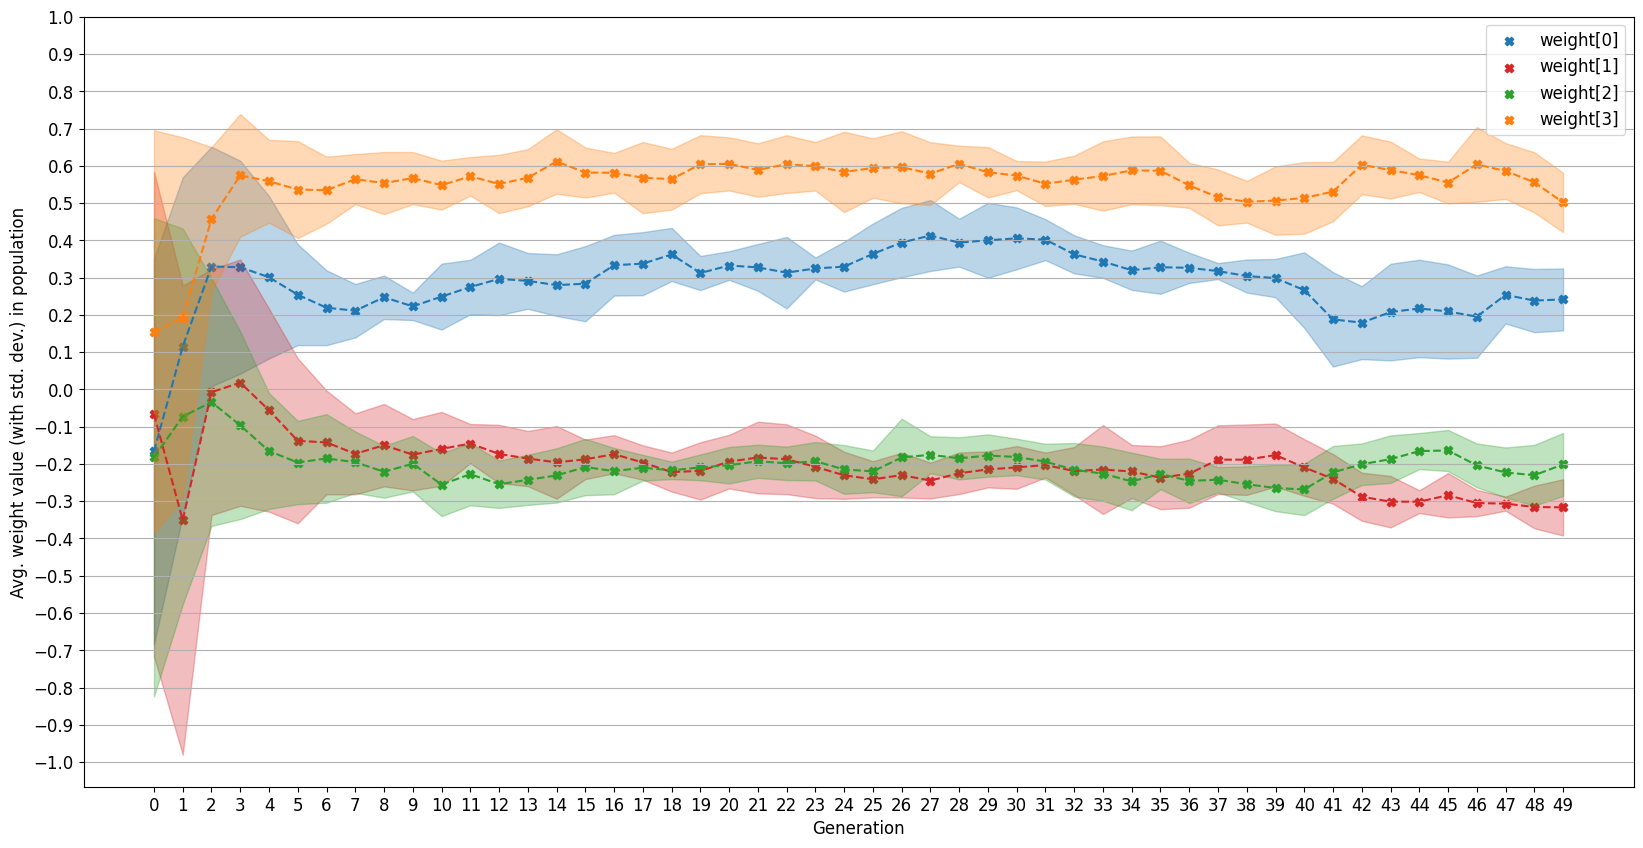

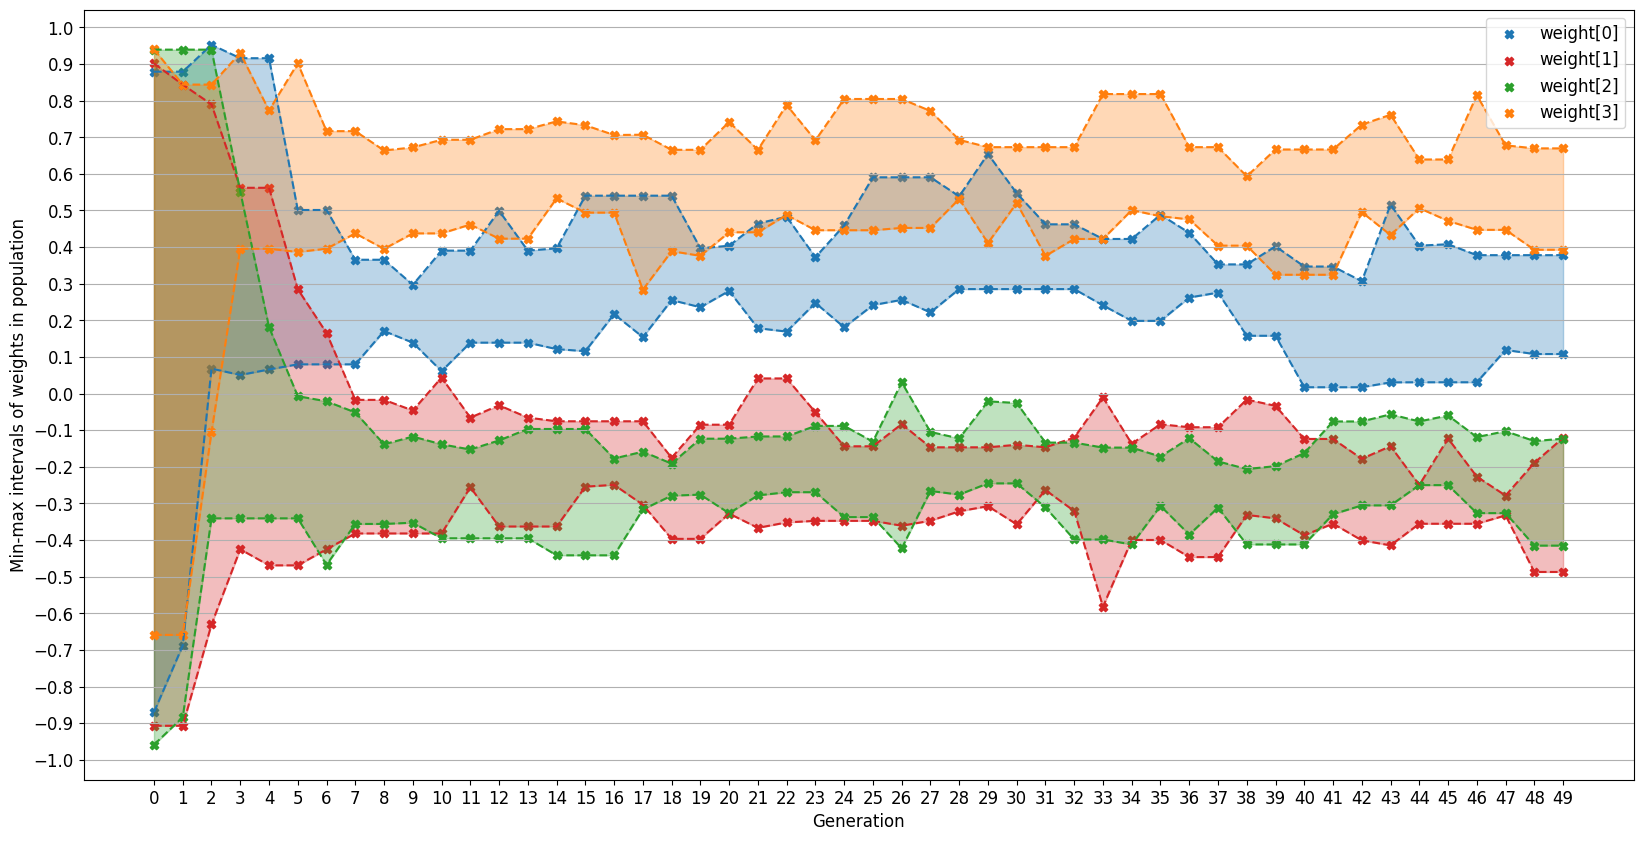

In [6]:
# load weight history and plot it
weight_history1 = joblib.load('weight_history1.gz')
plot_history(weight_history1, num_generations=50, mode='avg', filename='avg-weight-evolution1.png')
plot_history(weight_history1, num_generations=50, mode='min-max', filename='min-max-weight-evolution1.png')

In [221]:
make_bot_comparison(OptimizedBot(weights=[0.25648373, -0.31488939, -0.12317508, 0.48541348], verbose=False), RandomBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

OptimizedBot [0.25648373, -0.31488939, -0.12317508, 0.48541348] against RandomBot results (arena_size=15):
1634/2000 games won (81.7%)
264/2000 draws (13.2%)
102/2000 games lost (5.1%)


In [222]:
make_bot_comparison(OptimizedBot(weights=[0.25648373, -0.31488939, -0.12317508, 0.48541348], verbose=False), HeuristicBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

OptimizedBot [0.25648373, -0.31488939, -0.12317508, 0.48541348] against HeuristicBot results (arena_size=15):
549/2000 games won (27.45%)
482/2000 draws (24.1%)
969/2000 games lost (48.45%)


In [233]:
make_bot_comparison(HeuristicBot(verbose=False), RandomBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

HeuristicBot against RandomBot results (arena_size=15):
1706/2000 games won (85.3%)
214/2000 draws (10.7%)
80/2000 games lost (4.0%)


Conclusions for `OptimizedBot` with weights `[0.25648373, -0.31488939, -0.12317508, 0.48541348]`: 
* Results against `RandomBot` are similar to `HeuristicBot`'s.
* Results against `HeuristicBot` are underwhelming. Further optimization might be needed.

# Attempt 2
Parameters of evolution have been adjusted in hope of achieving a better result.
* Doubled `pop_size` (15->30)
* Decreased `num_generations` (50->30)
* Increased `mutation_prob` (0.5->0.6) and `mutation_scale` (0.1->0.15)
* Slightly decreased `tournament_size` (5->4)

In [244]:
weight_history2 = bot_evolution(arena_size=15, pop_size=30, num_generations=30, 
                                mutation_prob=0.6, mutation_scale=0.15, 
                                tournament_size=4, tournament_repetitions=2)

# save weight history
joblib.dump(weight_history2, 'weight_history2.gz', compress=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Best solution:
[0.41529055 0.12742814 0.38834967 0.00099525]


['weight_history2.gz']

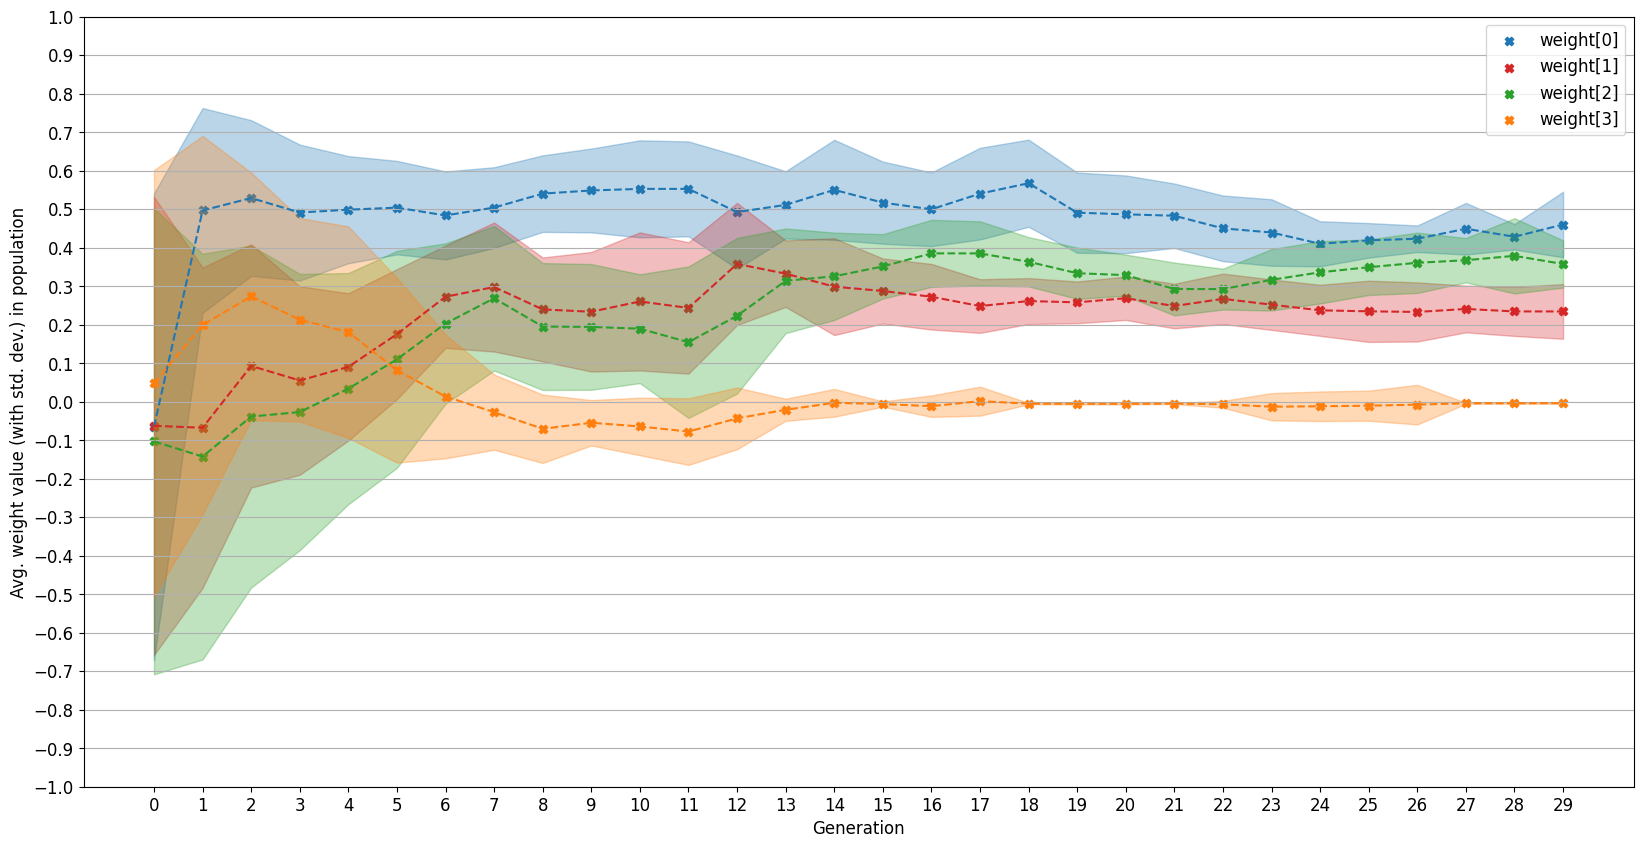

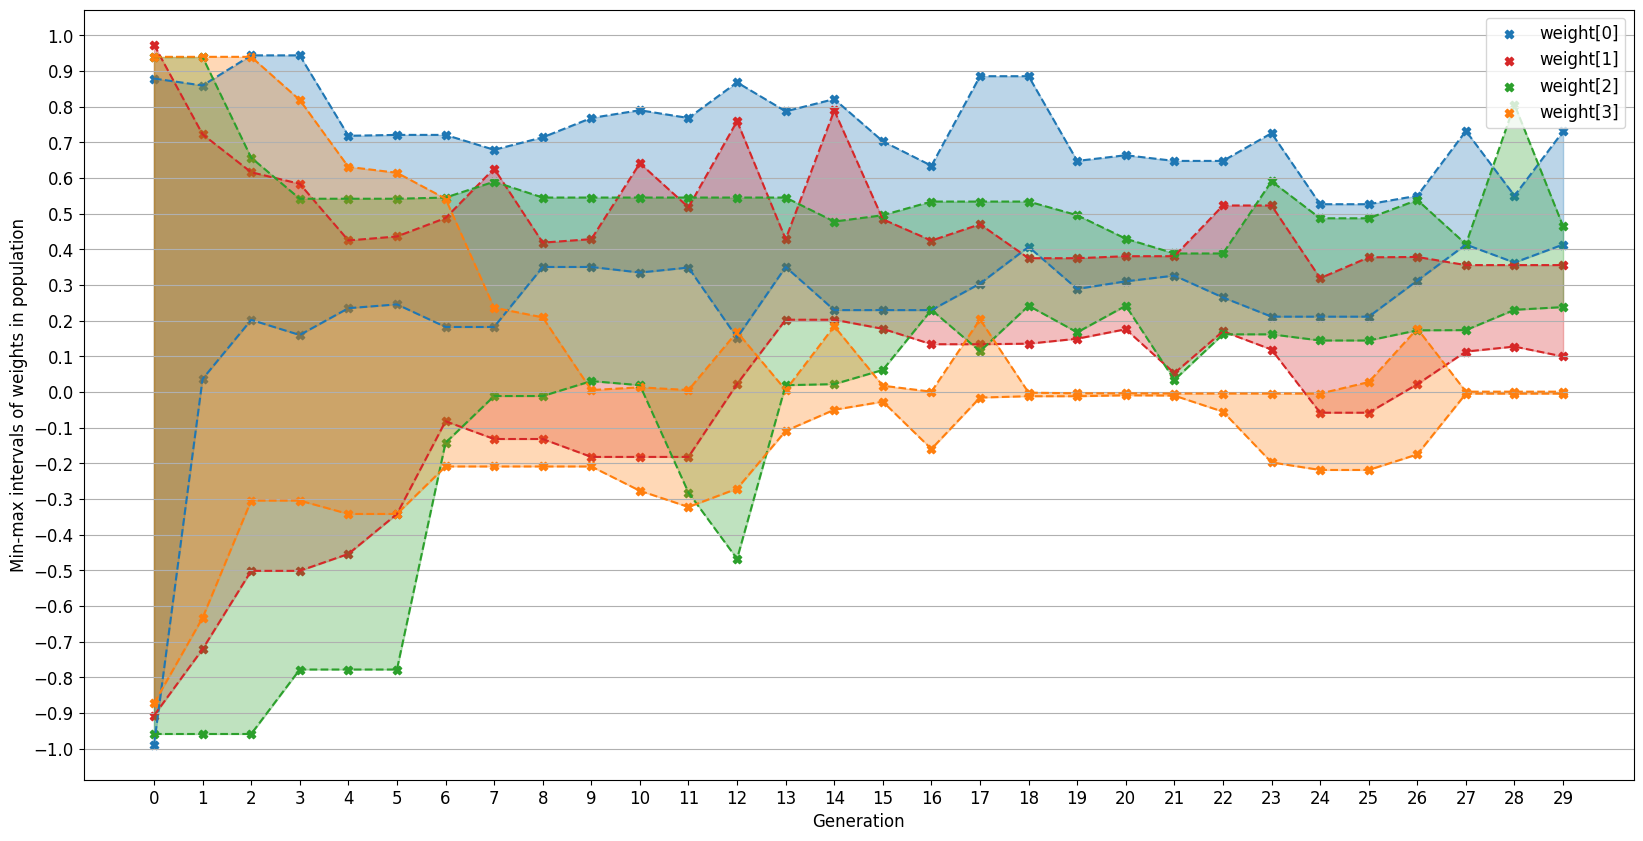

In [7]:
# load weight history and plot it
weight_history2 = joblib.load('weight_history2.gz')
plot_history(weight_history2, num_generations=30, mode='avg', filename='avg-weight-evolution2.png')
plot_history(weight_history2, num_generations=30, mode='min-max', filename='min-max-weight-evolution2.png')

In [246]:
make_bot_comparison(OptimizedBot(weights=[0.41529055, 0.12742814, 0.38834967, 0.00099525], verbose=False), RandomBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] against RandomBot results (arena_size=15):
1656/2000 games won (82.8%)
265/2000 draws (13.25%)
79/2000 games lost (3.95%)


In [247]:
make_bot_comparison(OptimizedBot(weights=[0.41529055, 0.12742814, 0.38834967, 0.00099525], verbose=False), HeuristicBot(verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] against HeuristicBot results (arena_size=15):
940/2000 games won (47.0%)
436/2000 draws (21.8%)
624/2000 games lost (31.2%)


In [248]:
make_bot_comparison(OptimizedBot(weights=[0.41529055, 0.12742814, 0.38834967, 0.00099525], verbose=False), 
                    OptimizedBot(weights=[0.25648373, -0.31488939, -0.12317508, 0.48541348], verbose=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] against OptimizedBot [0.25648373, -0.31488939, -0.12317508, 0.48541348] results (arena_size=15):
497/2000 games won (24.85%)
1503/2000 draws (75.15%)
0/2000 games lost (0.0%)


Conclusion for `OptimizedBot` with weights `[0.41529055, 0.12742814, 0.38834967, 0.00099525]`:
* Significantly better in every comparison. These will be the final weights for `OptimizedBot`.

## Verifying improvement during evolution vs previous generations

In [56]:
weight_history2 = joblib.load('weight_history2.gz')

In [57]:
pop_size = 30
num_weights = 4
populations_to_verify = [0, 5, 10, 15, 20, 25, 29]
bots_to_verify = []
for gen in populations_to_verify:
    pop = [[weight_history2[i][gen][j] for i in range(num_weights)] for j in range(pop_size)]
    best_solution = tournament_selection(pop, arena_size=15, repetitions=2, score_dict={'won': 3, 'lost': 0, 'drew': 1})
    bots_to_verify.append(OptimizedBot(weights=best_solution, verbose=False))
    print(f'Generation {gen} best solution is:\t {bots_to_verify[-1]}')

Generation 0 best solution is:	 OptimizedBot [0.7744254851526531, -0.05557014967610141, -0.7608115081233966, 0.42648957444599]
Generation 5 best solution is:	 OptimizedBot [0.45554295879998463, 0.30580145509243517, 0.009484507410296938, 0.015532736186659207]
Generation 10 best solution is:	 OptimizedBot [0.5151472033865464, 0.38344142278455956, 0.5452779049772134, 0.005520278335704024]
Generation 15 best solution is:	 OptimizedBot [0.5844990383867676, 0.2027148500264652, 0.37030916007839176, -0.004219100944132231]
Generation 20 best solution is:	 OptimizedBot [0.4134494320998266, 0.25739197681987286, 0.28954975466035404, -0.004551922484803626]
Generation 25 best solution is:	 OptimizedBot [0.4208139036571457, 0.25028453716511495, 0.41461272819003614, -0.004385511714467928]
Generation 29 best solution is:	 OptimizedBot [0.4152905499891564, 0.12742813608546422, 0.38834966661858683, 0.0009952539713151132]


In [64]:
comparison_results = []
comparison_labels = []

for i, bot1 in enumerate(bots_to_verify[1:]):
    gen1 = populations_to_verify[i+1]
    bot2 = bots_to_verify[i]
    gen2 = populations_to_verify[i]
    
    comp_label = f'Gen{gen1} vs Gen{gen2}'
    comparison_labels.append(comp_label)
    print(comp_label)
    
    comp_result = make_bot_comparison(bot1, bot2, num_seeds=500)
    comparison_results.append(comp_result)
    print('\n')

Gen5 vs Gen0


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.45554295879998463, 0.30580145509243517, 0.009484507410296938, 0.015532736186659207] against OptimizedBot [0.7744254851526531, -0.05557014967610141, -0.7608115081233966, 0.42648957444599] results (arena_size=15):
0/1000 games won (0.0%)
1000/1000 draws (100.0%)
0/1000 games lost (0.0%)


Gen10 vs Gen5


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.5151472033865464, 0.38344142278455956, 0.5452779049772134, 0.005520278335704024] against OptimizedBot [0.45554295879998463, 0.30580145509243517, 0.009484507410296938, 0.015532736186659207] results (arena_size=15):
405/1000 games won (40.5%)
499/1000 draws (49.9%)
96/1000 games lost (9.6%)


Gen15 vs Gen10


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.5844990383867676, 0.2027148500264652, 0.37030916007839176, -0.004219100944132231] against OptimizedBot [0.5151472033865464, 0.38344142278455956, 0.5452779049772134, 0.005520278335704024] results (arena_size=15):
500/1000 games won (50.0%)
1/1000 draws (0.1%)
499/1000 games lost (49.9%)


Gen20 vs Gen15


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.4134494320998266, 0.25739197681987286, 0.28954975466035404, -0.004551922484803626] against OptimizedBot [0.5844990383867676, 0.2027148500264652, 0.37030916007839176, -0.004219100944132231] results (arena_size=15):
547/1000 games won (54.7%)
33/1000 draws (3.3%)
420/1000 games lost (42.0%)


Gen25 vs Gen20


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.4208139036571457, 0.25028453716511495, 0.41461272819003614, -0.004385511714467928] against OptimizedBot [0.4134494320998266, 0.25739197681987286, 0.28954975466035404, -0.004551922484803626] results (arena_size=15):
467/1000 games won (46.7%)
336/1000 draws (33.6%)
197/1000 games lost (19.7%)


Gen29 vs Gen25


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.4152905499891564, 0.12742813608546422, 0.38834966661858683, 0.0009952539713151132] against OptimizedBot [0.4208139036571457, 0.25028453716511495, 0.41461272819003614, -0.004385511714467928] results (arena_size=15):
418/1000 games won (41.8%)
178/1000 draws (17.8%)
404/1000 games lost (40.4%)




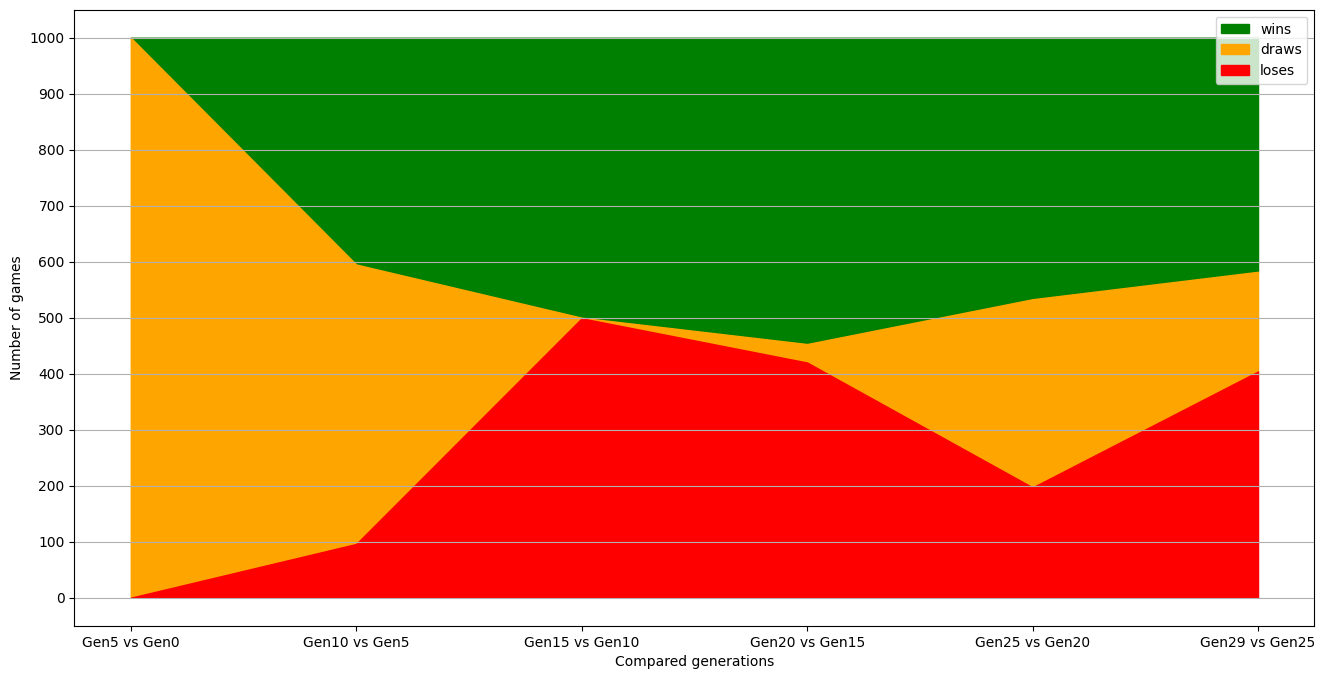

In [73]:
generation_comparison_plot(comparison_labels, comparison_results, 'gen-vs-previous-gen-evolution.jpg')

## Verifying improvement during evolution vs best bot

In [71]:
comparison_results2 = []
comparison_labels2 = []

for i, bot in enumerate(bots_to_verify):
    gen = populations_to_verify[i]
    
    comp_label = f'Gen{gen} vs best'
    comparison_labels2.append(comp_label)
    print(comp_label)
    
    comp_result = make_bot_comparison(bot, OptimizedBot(weights=[0.41529055, 0.12742814, 0.38834967, 0.00099525], verbose=False), num_seeds=500)
    comparison_results2.append(comp_result)
    print('\n')

Gen0 vs best


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.7744254851526531, -0.05557014967610141, -0.7608115081233966, 0.42648957444599] against OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] results (arena_size=15):
0/1000 games won (0.0%)
754/1000 draws (75.4%)
246/1000 games lost (24.6%)


Gen5 vs best


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.45554295879998463, 0.30580145509243517, 0.009484507410296938, 0.015532736186659207] against OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] results (arena_size=15):
0/1000 games won (0.0%)
250/1000 draws (25.0%)
750/1000 games lost (75.0%)


Gen10 vs best


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.5151472033865464, 0.38344142278455956, 0.5452779049772134, 0.005520278335704024] against OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] results (arena_size=15):
499/1000 games won (49.9%)
0/1000 draws (0.0%)
501/1000 games lost (50.1%)


Gen15 vs best


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.5844990383867676, 0.2027148500264652, 0.37030916007839176, -0.004219100944132231] against OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] results (arena_size=15):
405/1000 games won (40.5%)
106/1000 draws (10.6%)
489/1000 games lost (48.9%)


Gen20 vs best


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.4134494320998266, 0.25739197681987286, 0.28954975466035404, -0.004551922484803626] against OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] results (arena_size=15):
254/1000 games won (25.4%)
226/1000 draws (22.6%)
520/1000 games lost (52.0%)


Gen25 vs best


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.4208139036571457, 0.25028453716511495, 0.41461272819003614, -0.004385511714467928] against OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] results (arena_size=15):
397/1000 games won (39.7%)
179/1000 draws (17.9%)
424/1000 games lost (42.4%)


Gen29 vs best


  0%|          | 0/500 [00:00<?, ?it/s]

OptimizedBot [0.4152905499891564, 0.12742813608546422, 0.38834966661858683, 0.0009952539713151132] against OptimizedBot [0.41529055, 0.12742814, 0.38834967, 0.00099525] results (arena_size=15):
1/1000 games won (0.1%)
754/1000 draws (75.4%)
245/1000 games lost (24.5%)




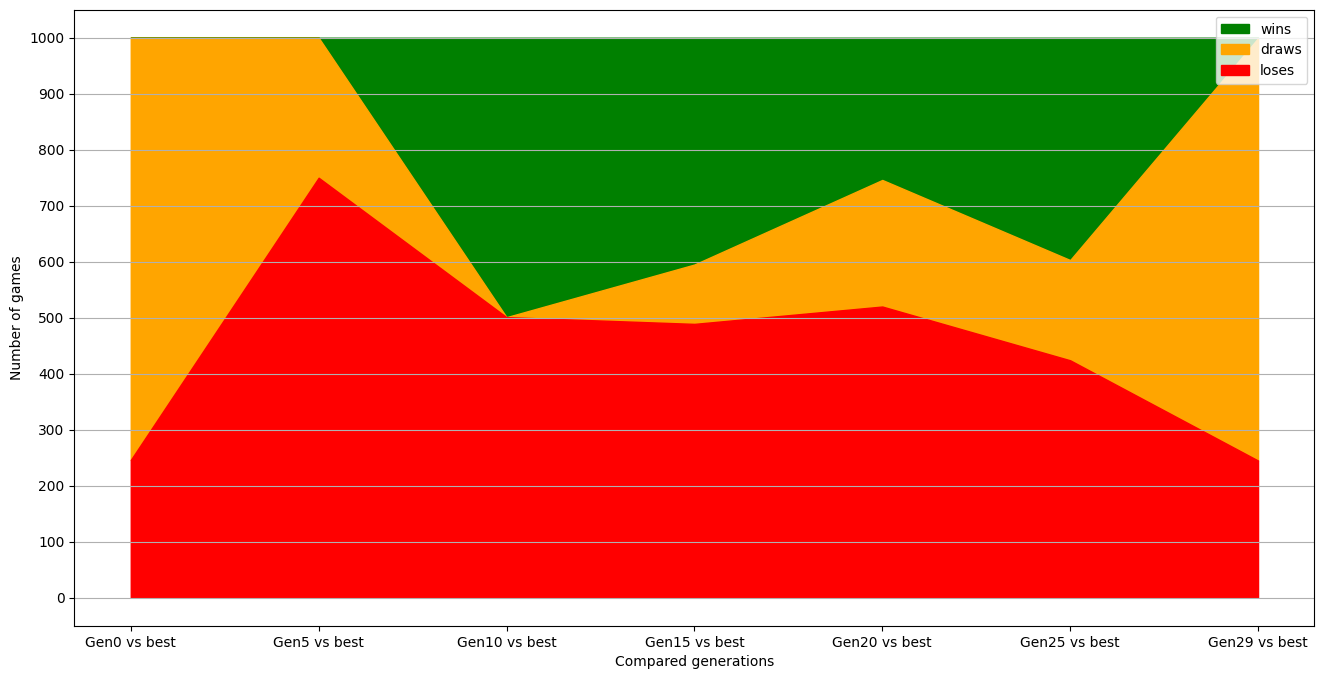

In [74]:
generation_comparison_plot(comparison_labels2, comparison_results2, 'gen-vs-best-evolution.jpg')